# Random Forest Baseline - LB 0.664
In this notebook we present a Random Forest baseline. We train GroupKFold models for each of the 18 questions. Our CV score is 0.664. We infer test using one of our KFold models. We can improve our CV and LB by engineering more features for our random forest and/or trying different models (like other ML models and/or RNN and/or Transformer). Also we can improve our LB by using more KFold models OR training one model using all data (and the hyperparameters that we found from our KFold cross validation).

In [1]:
import pandas as pd, numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import gc
import random
from tqdm import tqdm

# Load Train Data and Labels

In [2]:
f_label=open('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
for i,line in enumerate(f_label):
    pass
print(i)

424116


In [3]:
# 采样一部分行
def sample_row():
    with open('/kaggle/input/predict-student-performance-from-game-play/train.csv') as f:
#         f_label=open('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
        L=26296947
        head=f.readline()
#         head_label=f_label.readline()
        print(head.strip())
        with open('/kaggle/working/train_sample_rows.csv','w') as fw:
#             label_fw=open('/kaggle/working/train_label_sample_rows.csv','w')
            fw.write(head)
#             label_fw.write(head_label)
            for line in tqdm(f,total=L):
#                 line_label=f_label.readline()
                if random.random()<1/5000:
                    fw.write(line)
#                     label_fw.write(line_label)
#         f_label.close()
#         label_fw.close()
sample_row()
gc.collect()


session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group


100%|█████████▉| 26296946/26296947 [01:05<00:00, 403032.23it/s]


0

In [4]:
# 采样一部分列
# 26296947
def sample_column():
    with open('/kaggle/input/predict-student-performance-from-game-play/train.csv') as f:
        head=f.readline()
    #     print(head)
        head=head.strip().split(',')
        remove_i=[head.index('text'),head.index('room_fqid'),head.index('text_fqid')]
    #     remove_i=remove_i[::-1]
        remove_i.sort(reverse=True)
        print(remove_i)
        for i in remove_i:
            head.pop(i)
        head=','.join(head)+'\n'
    #     print(i,head.strip().split(',')[i])
        with open('/kaggle/working/train_sample_columns.csv','w') as fw:
            fw.write(head)
            for line in tqdm(f,total=26296946):
                line=line.strip().split(',')
                for i in remove_i:
                    line.pop(i)
                line=','.join(line)+'\n'
                fw.write(line)
sample_column()
gc.collect()

[15, 14, 12]


100%|██████████| 26296946/26296946 [01:25<00:00, 309141.83it/s]


0

In [5]:
train = pd.read_csv('/kaggle/input/train-sample-rows/train_sample_rows.csv',memory_map=True)
print( train.shape )
train.head()


(5259, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090314221187252,163,116451,navigate_click,undefined,3,NaN,159.503027,-140.000000,826.0,470.0,NaN,NaN,NaN,tunic.kohlcenter.halloffame,NaN,1,1,1,0-4
1,20090314221187252,729,872197,cutscene_click,basic,17,NaN,416.056246,-427.327551,817.0,624.0,NaN,undefined,savedteddy,tunic.historicalsociety.basement,tunic.historicalsociety.basement.savedteddy,1,1,1,13-22
2,20090314363702160,273,358499,person_click,basic,7,NaN,217.882601,-136.000000,684.0,466.0,NaN,"Sorry, I'm in a hurry.",worker,tunic.humanecology.frontdesk,tunic.humanecology.frontdesk.worker.intro,0,0,1,5-12
3,20090315085850788,852,2266002,navigate_click,undefined,19,NaN,-620.586508,-562.771396,581.0,758.0,NaN,NaN,NaN,tunic.wildlife.center,NaN,1,0,1,13-22
4,20090317111400710,72,99049,navigate_click,undefined,0,NaN,-406.189819,-51.390008,73.0,361.0,NaN,NaN,NaN,tunic.historicalsociety.closet,NaN,0,0,1,0-4


In [6]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [7]:
gc.collect()

21

# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB!

In [8]:
CATS = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

In [9]:
def feature_engineer(train):
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [10]:
train.shape

(5259, 20)

In [11]:
%%time
df = feature_engineer(train)
print( df.shape )
df.head()

(5009, 22)
CPU times: user 94.9 ms, sys: 5.86 ms, total: 101 ms
Wall time: 115 ms


,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
session_id,,,,,,,,,,,,,,,,,,,,,
20090314221187252,0-4,1,1,0,1,0,116451.0,3.0,-1.0,159.503027,...,470.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20090314221187252,13-22,1,1,1,1,1,872197.0,17.0,-1.0,416.056246,...,624.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20090314363702160,5-12,1,1,1,1,1,358499.0,7.0,-1.0,217.882601,...,466.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20090315085850788,13-22,1,1,0,1,0,2266002.0,19.0,-1.0,-620.586508,...,758.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20090317111400710,0-4,1,1,0,1,0,99049.0,0.0,-1.0,-406.189819,...,361.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Train Random Forest Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [12]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 21 features
We will train with 4707 users info


In [13]:
targets.shape

(424116, 4)

In [14]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf = RandomForestClassifier() 
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [15]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [16]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

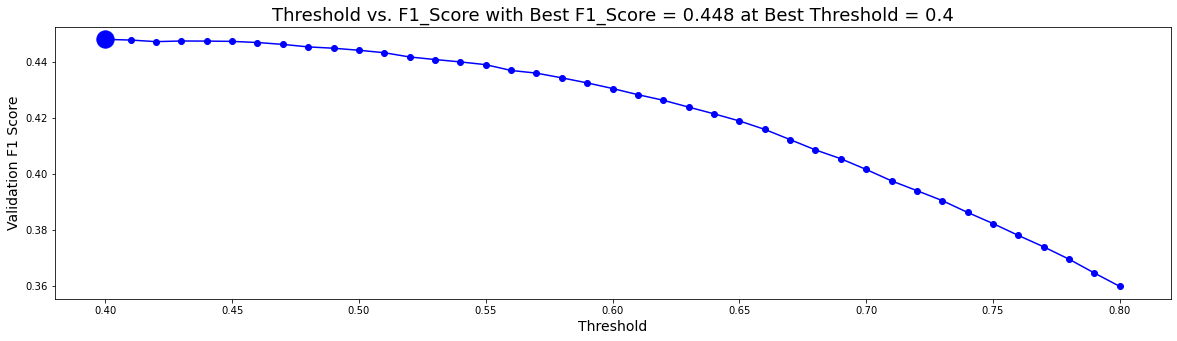

In [17]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [18]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.3562298953161897
Q1: F1 = 0.17127716381872216
Q2: F1 = 0.21174605761196247
Q3: F1 = 0.4169219764114732
Q4: F1 = 0.4644485713344303
Q5: F1 = 0.40699890907744285
Q6: F1 = 0.43045330026758466
Q7: F1 = 0.4666981110886508
Q8: F1 = 0.42787401831926464
Q9: F1 = 0.4594985319315221
Q10: F1 = 0.4597331879279846
Q11: F1 = 0.37045291732710084
Q12: F1 = 0.47683145445943365
Q13: F1 = 0.4821083351608495
Q14: F1 = 0.4856576079428281
Q15: F1 = 0.4741824794976495
Q16: F1 = 0.48324815538816734
Q17: F1 = 0.3832259333509157
==> Overall F1 = 0.4480892100591143


# Infer Test Data

In [19]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [20]:
t

18

In [21]:
tmp=[]
tests=[]
sample_submissions=[]
i=0
for (test, sample_submission) in iter_test:
    tests.append(test)
#     sample_submissions.append(sample_submission)
    print(i)
    i+=1
    x = feature_engineer(test)
    y = sample_submission.copy()
    y['session'] = y.session_id.apply(lambda x: int(x.split('_')[0]) )
    y['q'] = y.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
    y=y.set_index('session_id')
    for t in y['q'].unique():
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
        x_ = x.loc[x.level_group == grp]
        users = x_.index.values
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(x_[FEATURES].astype('float32'))[:,1]
        y.loc[x_.index.map(lambda x:str(x)+f'_q{t}'),'correct']=p>best_threshold
    y.correct=y.correct.astype('int')
    sample_submission['correct']=y.loc[sample_submission.session_id,'correct'].values
    tmp.append(sample_submission)
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
0
1
2


In [22]:
tmp=pd.concat(tmp)
tmp.reset_index(drop=True)

,session_id,correct
0,20090109393214576_q1,1
1,20090312143683264_q1,1
2,20090312331414616_q1,1
3,20090109393214576_q2,1
4,20090312143683264_q2,1
5,20090312331414616_q2,1
6,20090109393214576_q3,1
7,20090312143683264_q3,1
8,20090312331414616_q3,1
9,20090109393214576_q4,1


# EDA submission.csv

In [23]:
df = pd.read_csv('submission.csv')
print( df.shape )
df

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090312143683264_q1,1
2,20090312331414616_q1,1
3,20090109393214576_q2,1
4,20090312143683264_q2,1
5,20090312331414616_q2,1
6,20090109393214576_q3,1
7,20090312143683264_q3,1
8,20090312331414616_q3,1
9,20090109393214576_q4,1


In [24]:
print(df.correct.mean())

0.9444444444444444
